# AdaBoosting

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [2]:
from Preprocessing import *

In [3]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2,0
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2,1


## Entrenamiento

In [4]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

### Random Search

In [6]:
params = {'n_estimators': np.arange(25, 100),
          'learning_rate': [0.1, 0.2, 0.4, 0.7],
          'algorithm': ['SAMME', 'SAMME.R'],
         }

model_ada = AdaBoostClassifier(
        base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state=117)

rgscv = RandomizedSearchCV(
    model_ada, params, n_iter=60, scoring='roc_auc', cv=5, return_train_score=True
).fit(X_train, y_train)

In [7]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8516413131669808
Best params {'n_estimators': 61, 'learning_rate': 0.2, 'algorithm': 'SAMME'}


In [8]:
kf = StratifiedKFold(n_splits=5)

test_rocs = []
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    
    ada_boosting = AdaBoostClassifier(
        base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
        random_state=117,
        n_estimators = rgscv.best_params_['n_estimators'],
        learning_rate = rgscv.best_params_['learning_rate'],
        algorithm = rgscv.best_params_['algorithm']
    )
    ada_boosting.fit(X.iloc[train_index], y.iloc[train_index])
    test_roc = roc_auc_score(y.iloc[test_index], ada_boosting.predict(X.iloc[test_index]))
    print(f"fold {fold_idx}: auc roc score is {test_roc:.4f}")
    test_rocs.append(test_roc)
print(f"mean test auc roc is: {np.mean(test_rocs):.4f}")

fold 0: auc roc score is 0.7660
fold 1: auc roc score is 0.7931
fold 2: auc roc score is 0.8511
fold 3: auc roc score is 0.8020
fold 4: auc roc score is 0.7966
mean test auc roc is: 0.8017


## Metricas

### AUC ROC

In [9]:
roc = roc_auc_score(y_test, ada_boosting.predict_proba(X_test)[:,1])
print(f"{roc:.4f}")

0.9123


### Accuracy

In [10]:
acc = accuracy_score(y_test, ada_boosting.predict(X_test))
print(f"{acc:.4f}")

0.8756


### Precision

In [11]:
precision = precision_score(y_test, ada_boosting.predict(X_test))
print(f"{precision:.4f}")

0.8451


### Recall

In [12]:
recall = recall_score(y_test, ada_boosting.predict(X_test), pos_label=0)
print(f"{recall:.4f}")

0.9134


### Matriz de confusion

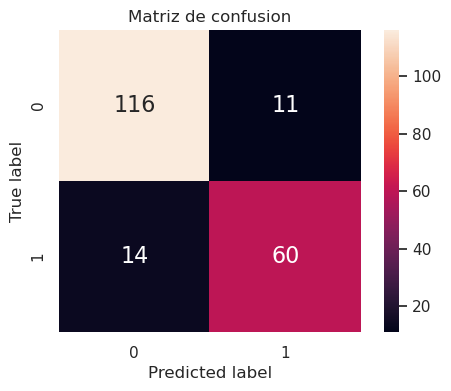

In [13]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, ada_boosting.predict(X_test))

## Test Holdout

In [14]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
holdout.head(5)

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


In [15]:
df_h = prepod_tp1_un_df(holdout)
df_h = replace_nulls_edad(df_h, 'media')
df_h = encodear_atributos_categoricos(df_h)
df_h = df_h.drop(['volveria'], axis=1)
df_h.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,650,0,1,26.0,0,0,1,0,0,1,0
1,0,0,1,234,0,1,8.0,4,2,4,0,0,1,6
2,0,1,0,31,1,0,43.0,0,0,3,0,1,0,0
3,0,1,1,552,1,0,30.0,0,0,3,0,0,1,0
4,0,0,1,411,1,0,32.8,0,0,1,0,0,1,0


In [16]:
y_pred = ada_boosting.predict(df_h)
y_pred

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1])

In [17]:
(y_pred.shape, df_h.shape)

((90,), (90, 14))

In [18]:
serie_predicha = pd.Series(y_pred, name='volveria') 
serie_predicha = serie_predicha.to_frame()
serie_predicha.head(10)

,volveria
0,0
1,0
2,1
3,1
4,1
5,0
6,0
7,1
8,1
9,0


In [19]:
df_predicho = holdout.join(serie_predicha, how='inner')
cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,1
3,552,1
4,411,1


In [20]:
df_resultado.shape

(90, 2)

In [21]:
df_resultado.to_csv('prediccion/Ada_boosting_resultado_final.csv')